***
## Anomaly/Outlier Detection Model with PyOD and AutoEncoder 
 
L. Saetta   04/2020

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from numpy.random import seed

sns.set(color_codes=True)
%matplotlib inline

# code for Tensorflow 2 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.')

2.1.0


### Step 1: create a single data file

In [2]:
RESULT_FILE_NAME = "BearingNasaTest1.csv"

### Step 2: load from the single datafile

In [3]:
# Step 2: legge i dati da file
result_data = pd.read_csv(RESULT_FILE_NAME, index_col = 0)

# attenzione, il formato della data è cambiato
result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [4]:
result_data.head()

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


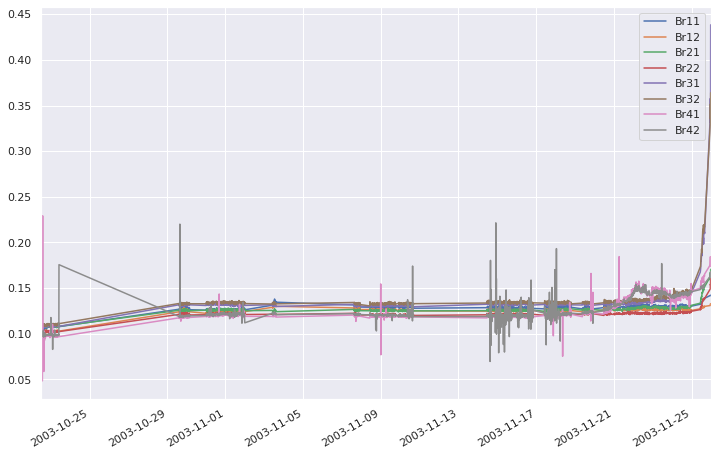

In [5]:
# plot all data
result_data.plot(figsize = (12,8))

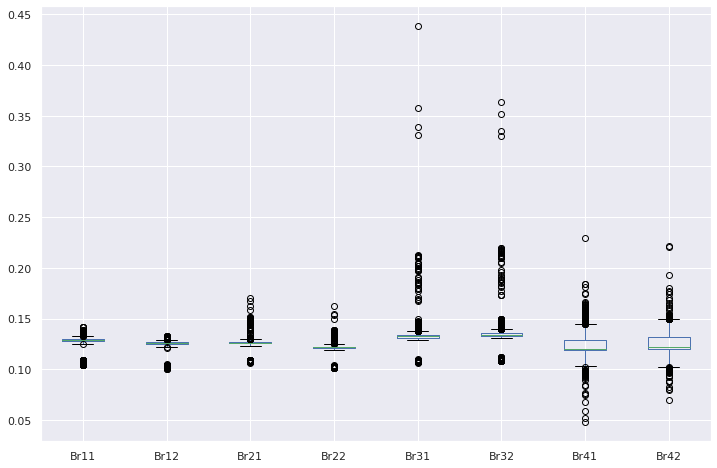

In [6]:
plt.figure(figsize = (12,8))

result_data.boxplot()

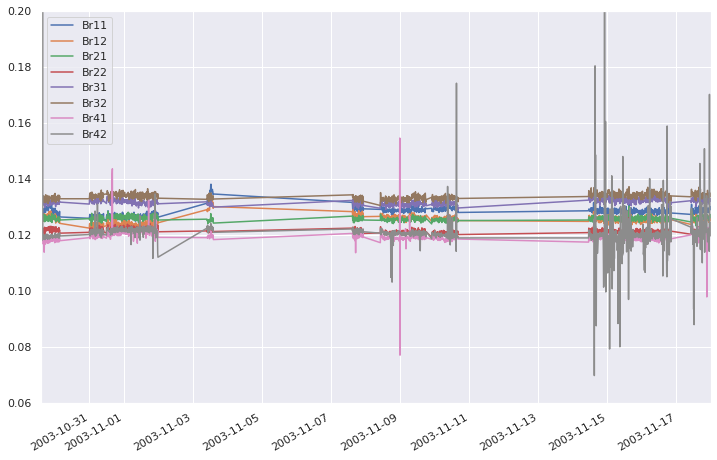

In [7]:
# prendo prima parte dati come train !!!
dataset_train = result_data['2003-10-25 00:00:01':'2003-11-17 23:59:00']
dataset_test = result_data['2003-11-17 23:59:00':]

# vibrazioni normali
dataset_train.plot(figsize = (12,8), ylim = (0.06, 0.2))

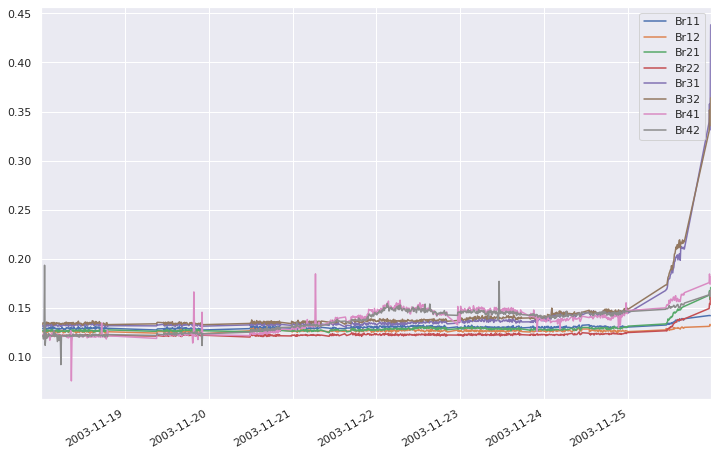

In [8]:
# come si vede da un certo punto le vibrazioni aumentano 
# e quelle di un cuscinetto "esplodono"
dataset_test.plot(figsize = (12,8))

In [9]:
# porto le feature sulla stessa scala...
scaler = preprocessing.MinMaxScaler()

# ovviamente lo scaler è addestrato soltanto sul training test
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns = dataset_train.columns, 
                       index = dataset_train.index)

# e lo stesso scaler è usato sul test set (non si devono contaminare)
X_test = pd.DataFrame(scaler.transform(dataset_test), columns = dataset_test.columns, 
                      index = dataset_test.index)

#### Define the Autoencoder (NN)

In [10]:
# define the NN
# 8 - 6 - 2 - 6 - 8

seed(1234)
tf.random.set_seed(1234)

input_num = X_train.shape[1]
myreg = keras.regularizers.l1(10e-5)

# Input layer:
model = Sequential()

# First hidden layer, connected to input vector X. 
model.add(Dense(6, activation = "relu",
                # suggested from Chollet Blog on Autoencoders
                activity_regularizer = myreg,
                input_shape=(input_num,)
               )
         )
model.add(Dense(2,activation = "relu", activity_regularizer = myreg))
model.add(Dense(6, activation = "relu"))
model.add(Dense(input_num))

model.compile(loss='mse',optimizer='adam')

In [11]:
# as we can see the network has input = 8, output = 8 !!!
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model (120 epochs)
NUM_EPOCHS = 120
BATCH_SIZE = 10
VAL_SPLIT = 0.1
NO_VERBOSE = 0

X = np.array(X_train)

history = model.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = NO_VERBOSE)

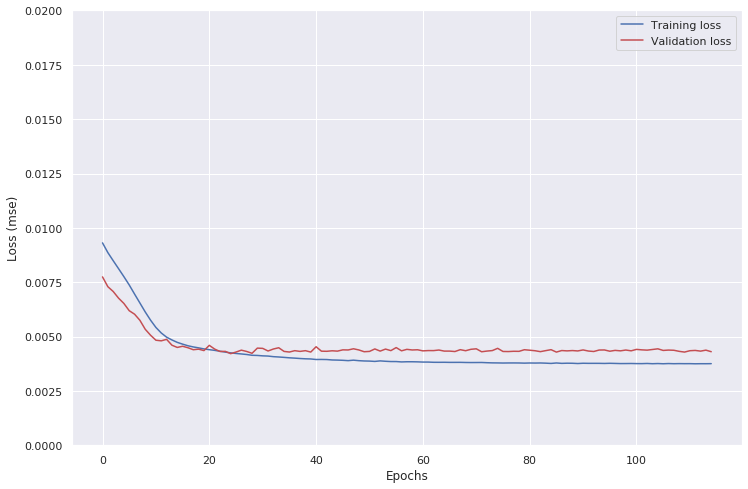

In [13]:
# visualizziamo la parte finale
plt.figure(figsize = (12,8))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss[5:],'b', label='Training loss')
plt.plot(hist_val_loss[5:],'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0,.02])

plt.show()

In [14]:
# save the model
model.save('autoencoder1.h5')

(0.0, 0.16)

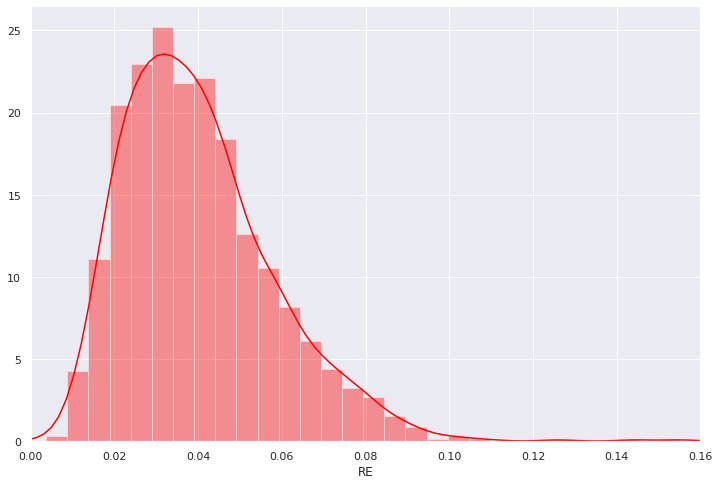

In [15]:
# predizioni su train
# RE: reconstruction error, calcolato come MAE

# predict
X_pred = model.predict(np.array(X_train))

X_pred = pd.DataFrame(X_pred, columns=X_train.columns, index = X_train.index)

scored = pd.DataFrame(index = X_train.index)

# per ogni predizione calcolo lo scostamento, come MAE
scored['RE'] = np.mean(np.abs(X_pred - X_train), axis = 1)

plt.figure(figsize = (12,8))

# disegno istogramma
sns.distplot(scored['RE'], bins = 30, kde= True, color = 'red');

plt.xlim([0.0,.16])

In [16]:
# dal grafico sopra... 3 sigma
THRESHOLD = 0.1

In [17]:
# calcoliamo le predizioni su TEST
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, columns = X_test.columns, index = X_test.index)

score = pd.DataFrame(index = X_test.index)
score['RE'] = round(np.mean(np.abs(X_pred - X_test), axis = 1), 4)

# prendiamo come soglia 0.11 (vedi grafico precedente)
score['Threshold'] = THRESHOLD
score['Anomaly'] = score['RE'] > score['Threshold']

# vediamo le predizioni sugli ultimi dati
score.tail(5)

,RE,Threshold,Anomaly
2003-11-25 16:07:32,1.5157,0.1,True
2003-11-25 23:13:21,4.7535,0.1,True
2003-11-25 23:19:56,5.2051,0.1,True
2003-11-25 23:29:56,4.8022,0.1,True
2003-11-25 23:39:56,6.0478,0.1,True


In [18]:
# i dati finali sono tutti anomali... OK

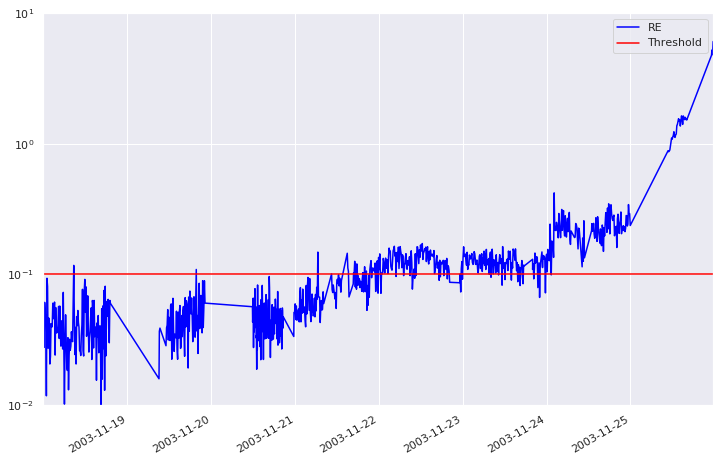

In [19]:
# grafico con scala logaritmica su asse y
score.plot(logy=True,  figsize = (12,8), ylim = [1e-2,1e1], color = ['blue','red'])

In [20]:
# dal grafico vediamo che, potenzialmente, con 4-5 gg di anticipo saremmo in grado di prevedere il fault !!!

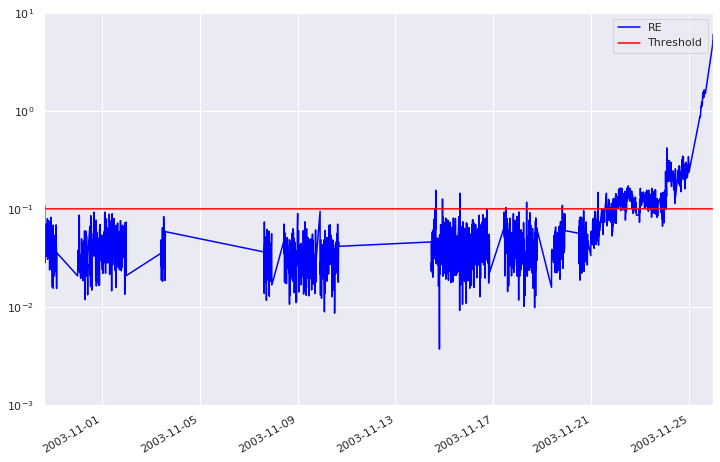

In [21]:
# vediamo anche nel periodo di training...
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns = X_train.columns, index = X_train.index)

score_train = pd.DataFrame(index = X_train.index)
score_train['RE'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
score_train['Threshold'] = THRESHOLD
score_train['Anomaly'] = score_train['RE'] > score_train['Threshold']

# effettuo concatenazione dei due dataframe
score = pd.concat([score_train, score])

score.plot(logy=True,  figsize = (12,8), ylim = [1e-3,1e1], color = ['blue','red'])

### Now we build the network with Functional API

In [22]:
# define the NN

seed(1234)
tf.random.set_seed(1234)

input_vec = Input(shape=(input_num,))

# encoder
encoded = Dense(6, activation='relu', activity_regularizer = myreg)(input_vec)
encoded = Dense(2, activation='relu', activity_regularizer = myreg)(encoded)

# decoder
decoded = Dense(6, activation='relu')(encoded)
decoded = Dense(input_num)(decoded)

In [23]:
# the complete network
autoencoder = Model(input_vec, decoded)

In [24]:
# only the encoder
encoder = Model(input_vec, encoded)

In [25]:
autoencoder.compile(optimizer='adam', loss='mse')

In [26]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [27]:
history2 = autoencoder.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = 0)

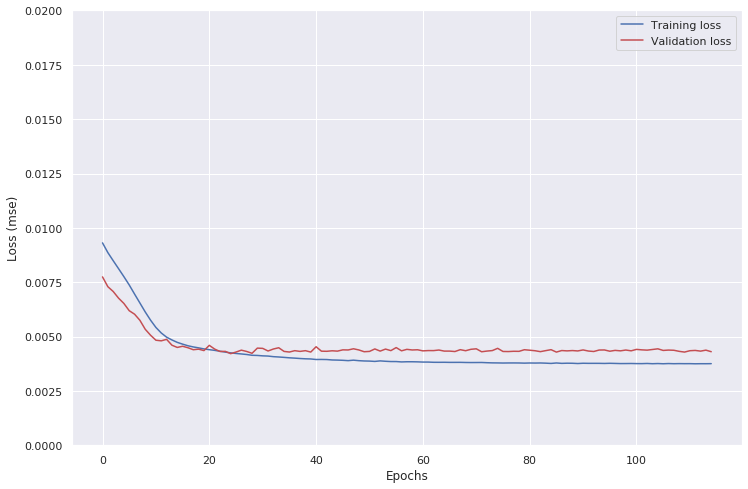

In [28]:
# visualizziamo la parte finale
plt.figure(figsize = (12,8))
hist_loss = history2.history['loss']
hist_val_loss = history2.history['val_loss']

plt.plot(hist_loss[5:],'b', label='Training loss')
plt.plot(hist_val_loss[5:],'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0,.02])

plt.show()

In [29]:
# ovviamente il training segue la stessa strada

In [30]:
# sul dataset di test la codifica (in 2 dim.)
H_pred = encoder.predict(np.array(X_test))
H_pred = pd.DataFrame(H_pred, index = X_test.index)
H_pred['Anomaly'] = score['Anomaly']

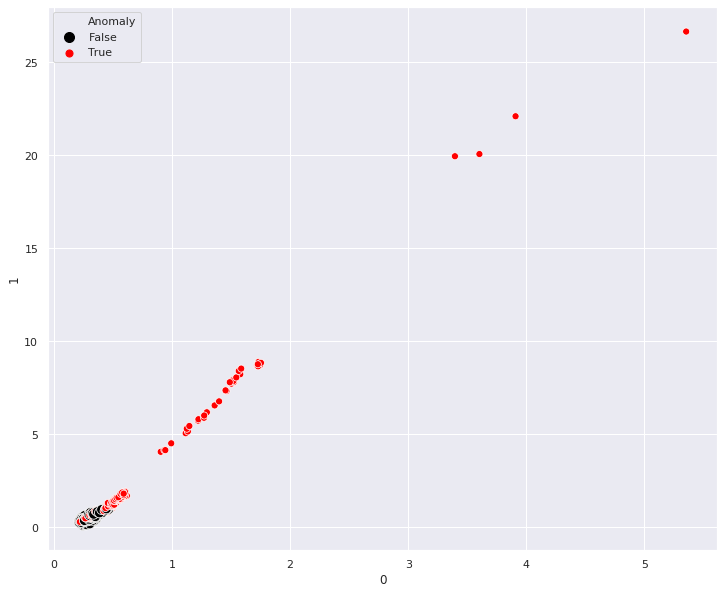

In [31]:
# scatter plot
# H_pred.plot.scatter(x = 0, y = 1, figsize = (12,8))
plt.figure(figsize = (12,10))

sns.scatterplot(x= 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = H_pred, palette=['black','red'], legend='full')

In [32]:
# esploriamo meglio il cluster vicino all'origine
condition = ((H_pred[0] < 1) & (H_pred[1] < 4))

In [33]:
select = H_pred[condition]

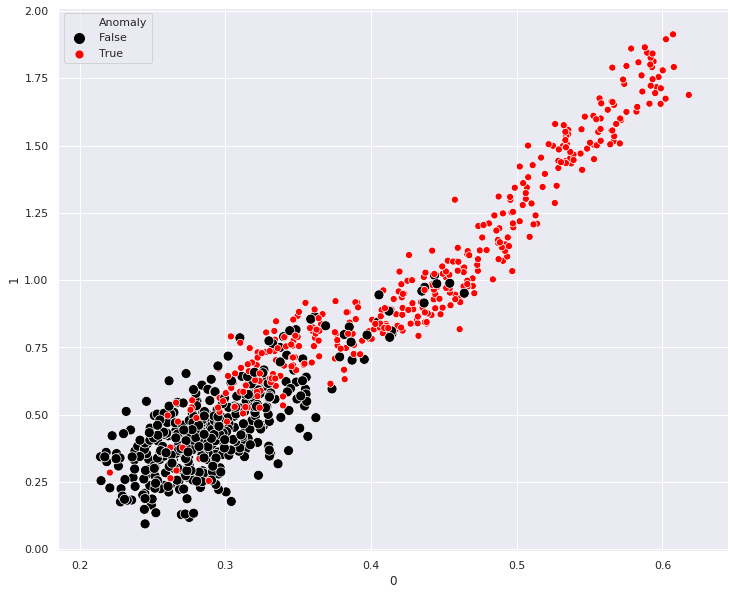

In [34]:
plt.figure(figsize = (12,10))

sns.scatterplot(x = 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = select, palette=['black','red'], legend='full')